# Анализ комментариев оппозиционного ютуба

## Введение

Иногда хочется простого

## Технические моментики

### Установка зависимостей

In [244]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [245]:
import pandas as pd
import numpy as np
import scipy.stats as sts

import re
import time
from tqdm import tqdm
import datetime
import sqlite3
from collections import defaultdict

### Для того, чтобы загружать файлы с ЯД
from urllib.parse import urlencode
from urllib.request import urlretrieve
import requests

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_theme(style='darkgrid')

In [246]:
'''
Эта функция нужна, чтобы подгружать файлы с Яндекс Диска.
Принцип подсмотрел тут:
https://thgtsprog.blogspot.com/2020/06/csv-c.html
'''
def from_yaDisk(link):
    yadisk = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    response = requests.get(yadisk + urlencode({'public_key': link}))
    return response.json()['href']

### Подгружаем базу данных

In [247]:
local_db = 'db.db' # создаем локальное имя

urlretrieve(from_yaDisk('https://disk.yandex.ru/d/Q6113g0lizxkvw'), local_db) # скачиваем файл с ЯД

# Подключаемся к базе
sql_conn = sqlite3.connect(local_db)
cursor = sql_conn.cursor()

### Немного технических функций, чтоб красиво было

In [248]:
channels_id = pd.read_json(from_yaDisk('https://disk.yandex.ru/d/0DkqqDrltIPAgg'))
channels_id = channels_id.set_index('id')

In [249]:
def channel_name(userid):
    """
    Во всех базах каналы можно выделить по
    их id. Эта функция переводит id в
    читаемое название
    """
    global channels_id
    l = channels_id.loc[userid, 'links']

    custom_url = r'https?://(?:www\.)?youtube\.com/@([A-Za-zА-я0-9_-]+)'

    return re.match(custom_url, l).group(1)

## Предварительная обработка данных

### Для начала, посмотрим, есть ли в базе данных пропуки вообще

In [250]:
### извлечём название столбцов
def columns_for_where():
    cursor.execute('PRAGMA table_info(comments)')
    df_columns = [i[1] for i in cursor.fetchall()]
    return " ISNULL OR ".join(df_columns) + " ISNULL"

cursor.execute(f'SELECT * FROM comments WHERE {columns_for_where()}')
cursor.fetchall()

[]

Как видим, в базе нет пропусков (еще бы они были, учитывая, как она собиралась). Посмотрим, какие столбцы у нас есть

### Опишем отслеживаемые параметры

In [251]:
cursor.execute('PRAGMA table_info(comments)')
cursor.fetchall()

[(0, 'channelId', 'TEXT', 1, None, 0),
 (1, 'videoId', 'TEXT', 1, None, 0),
 (2, 'userId', 'TEXT', 1, None, 0),
 (3, 'videoDate', 'DATETIME', 0, None, 0),
 (4, 'commentDate', 'DATETIME', 0, None, 0),
 (5, 'commentText', 'TEXT', 1, None, 0),
 (6, 'likeCount', 'INTEGER', 0, None, 0),
 (7, 'totalReplyCount', 'INTEGER', 0, None, 0)]

1. channelId -- столбец содержит в себе уникальный идентификатор канала, тип данных -- str
2. videoId -- в этом столбце содержаться уникальые идентификаторы видео, тип данных -- str
3. userId -- тут содержатся идентификаторы комментаторов
4. videoDate -- дата выхода видео, datetime
5. commentDate -- дата публикации комментария, datetime
6. commentText -- текст комментария
7. likeCount -- счетчик лайков под комментариями
8. totalReplyCount -- счетчик ответов под комментариями

## Переходим в pandas и создаем новые признаки

### Переход к pandas

In [252]:
cursor.execute('SELECT DISTINCT channelId from comments')
channels = list(list(zip(*cursor.fetchall()))[0])
df = pd.read_sql_query('SELECT * FROM comments', sql_conn) ### делаем sql-запрос и считываем его в DataFrame

In [253]:
def rplc(s):
  return s.replace('+00:00', '')

In [254]:
df['videoDate'] = df['videoDate'].apply(rplc).astype('datetime64[s]')
df['commentDate'] = pd.to_datetime(df['commentDate']).dt.tz_localize(None)
df['commentDate'] = df['commentDate'].astype('datetime64[ns]')

In [255]:
df.head(3)

,channelId,videoId,userId,videoDate,commentDate,commentText,likeCount,totalReplyCount
0,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC2diJqEViME5uo5ZG7XrCQg,2025-03-15 11:10:24,2025-03-15 12:51:18,В одном из выступлений Зеленский выразил своё ...,0,0
1,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC5b1UGWXS6p31JGnxjUwGMg,2025-03-15 11:10:24,2025-03-15 12:47:44,Явлинский как всегда и на елку хочет влезть и ...,0,0
2,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCQrSu4s5smVN6PRSR1-3Ygw,2025-03-15 11:10:24,2025-03-15 12:44:37,"Раньше я господина Явлинского не долюбливал, к...",1,0


### Создаем новые признаки

У нас есть даты и время публикаций видео и комментариев, а также сам текст комментария. Таким образом, можем добавить несколько дополнительных признаков:
1. Разность между временами выхода видео и публикации комментария
2. Длина комментария
3. Номер дня недели, когда опубликован комментарий, где 0 -- понедельник, 6 -- воскресенье
Эти признаки я собираюсь в дальнейшем использовать для оценки того, с какой вероятностью комментарий вызовет дискуссию

In [256]:
def textlen(comm):
    comm = comm.lower()
    comm = re.sub(r'\d+', '', comm)
    comm = re.sub(r'[^\w\s]', '', comm)
    return len(comm.split(' '))

def weektime(date):
    start_week = date - pd.Timedelta(days=date.weekday())
    return (date - start_week.normalize()).total_seconds()

def weekday(date):
    return ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'][date.weekday()]

In [257]:
df['commentLag'] = df['commentDate'].values - df['videoDate'].values
df['commentLen'] = df['commentText'].apply(textlen)
df['weektimeComm'] = df['commentDate'].apply(weektime)
df['weektimeVideo'] = df['videoDate'].apply(weektime)
df['weekDayComm'] = df['commentDate'].apply(weekday)

# технические параметры
df['channel'] = df['channelId'].apply(channel_name)

df.head(3)

,channelId,videoId,userId,videoDate,commentDate,commentText,likeCount,totalReplyCount,commentLag,commentLen,weektimeComm,weektimeVideo,weekDayComm,channel
0,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC2diJqEViME5uo5ZG7XrCQg,2025-03-15 11:10:24,2025-03-15 12:51:18,В одном из выступлений Зеленский выразил своё ...,0,0,0 days 01:40:54,19,478278.0,472224.0,Сб,zhivoygvozd
1,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC5b1UGWXS6p31JGnxjUwGMg,2025-03-15 11:10:24,2025-03-15 12:47:44,Явлинский как всегда и на елку хочет влезть и ...,0,0,0 days 01:37:20,25,478064.0,472224.0,Сб,zhivoygvozd
2,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCQrSu4s5smVN6PRSR1-3Ygw,2025-03-15 11:10:24,2025-03-15 12:44:37,"Раньше я господина Явлинского не долюбливал, к...",1,0,0 days 01:34:13,22,477877.0,472224.0,Сб,zhivoygvozd


### Посмотрим на commentLag
Время между выходом видео и публикацией комментария записана в столбец commentLag. Однако комментарии можно оставлять не только под видео, но и под стримами, которые от видео в таблице неотличимы. Найдем такие комментарии, и удалим их, поскольку они будут сильно искажать нашу выборку

In [258]:
(df['commentLag'] <= np.timedelta64(0)).sum()

np.int64(1085)

In [259]:
df.drop(df[df['commentLag'] <= np.timedelta64(0)].index, inplace=True)
df.head()

,channelId,videoId,userId,videoDate,commentDate,commentText,likeCount,totalReplyCount,commentLag,commentLen,weektimeComm,weektimeVideo,weekDayComm,channel
0,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC2diJqEViME5uo5ZG7XrCQg,2025-03-15 11:10:24,2025-03-15 12:51:18,В одном из выступлений Зеленский выразил своё ...,0,0,0 days 01:40:54,19,478278.0,472224.0,Сб,zhivoygvozd
1,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC5b1UGWXS6p31JGnxjUwGMg,2025-03-15 11:10:24,2025-03-15 12:47:44,Явлинский как всегда и на елку хочет влезть и ...,0,0,0 days 01:37:20,25,478064.0,472224.0,Сб,zhivoygvozd
2,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCQrSu4s5smVN6PRSR1-3Ygw,2025-03-15 11:10:24,2025-03-15 12:44:37,"Раньше я господина Явлинского не долюбливал, к...",1,0,0 days 01:34:13,22,477877.0,472224.0,Сб,zhivoygvozd
3,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCzaanybiST-Wq58x_A5EGLA,2025-03-15 11:10:24,2025-03-15 12:44:25,"Патока и елей, Европа никуда не годна,Трамп мо...",0,0,0 days 01:34:01,13,477865.0,472224.0,Сб,zhivoygvozd
4,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCThmJkK84pPXYnXci3U94mA,2025-03-15 11:10:24,2025-03-15 12:42:01,Хочется задать один вопрос Явлинскому. Вы не х...,1,1,0 days 01:31:37,26,477721.0,472224.0,Сб,zhivoygvozd


In [260]:
(df['commentLag'] <= np.timedelta64(0)).sum()

np.int64(0)

## Предварительный и визуальный анализ

Для начала, по всем каналам, построим гистограммы распределений задержки комментирования, длины комментария и количества ответов на комментариях

<ipython-input-261-c16da4fa8c1a>:19: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df['totalReplyCount'].values),


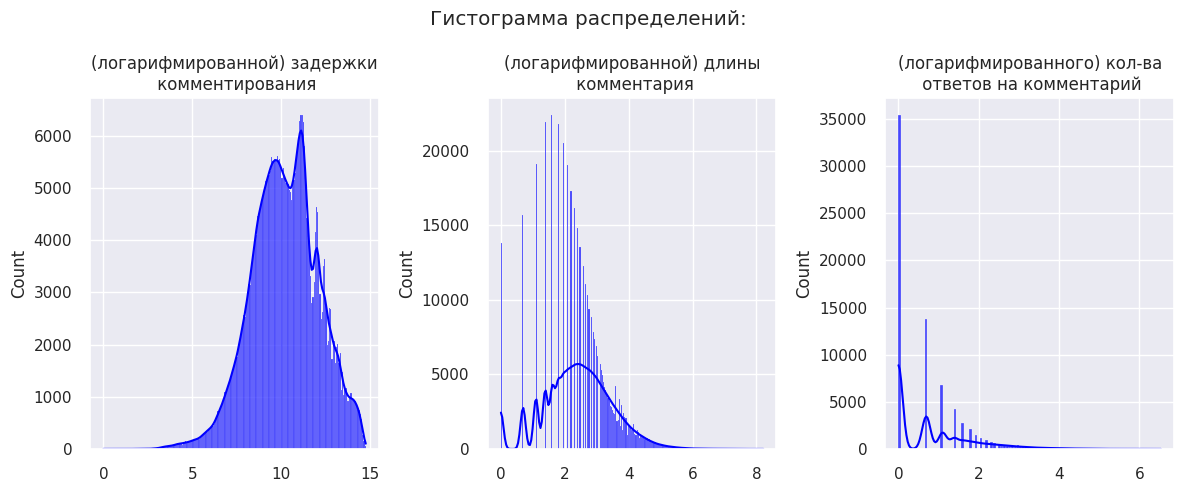

In [261]:
plt.figure(figsize=(12, 5))
plt.suptitle('Гистограмма распределений: ')

# Распределение задержки комментирования
plt.subplot(1, 3, 1)
plt.title('(логарифмированной) задержки\n комментирования')
sns.histplot(np.log(df['commentLag'].dt.total_seconds().values),
             kde=True, alpha=.7, color='blue')

# Распределение длин комментариев
plt.subplot(1, 3, 2)
plt.title('(логарифмированной) длины\n комментария')
sns.histplot(np.log(df['commentLen'].values),
             kde=True, alpha=.7, color='blue')

# Распределение количества ответов на коммментарии
plt.subplot(1, 3, 3)
plt.title('(логарифмированного) кол-ва\n ответов на комментарий')
sns.histplot(np.log(df['totalReplyCount'].values),
             alpha=.7, color='blue', kde=True);
plt.tight_layout();

Видно, что задержка комментирования и длина комментариев похожи на логнормальные (шум в низких значениях длин комментариев объясняется тем, что хоть сколь-нибудь осмысленный комментарий сложно написать из менее чем $\sim e^3$ слов).
Количество ответов на комментарий при логарифмировании стал более медленно снижаться, но общий Паттерн сохранил. Это говорит о том, что их распределение, вероятно, описывается степенной функцией распределения.

На слеждующих графиках можно посмотреть, что для отдельных каналов закономерность сохраняется. Эта часть не очень информативная, ее можно пропустить. Также в ней в DataFrame добавляются логарифмированные столбцы с зфдержкой комментирования и длиной комментария

### Распределения для отдельных каналов

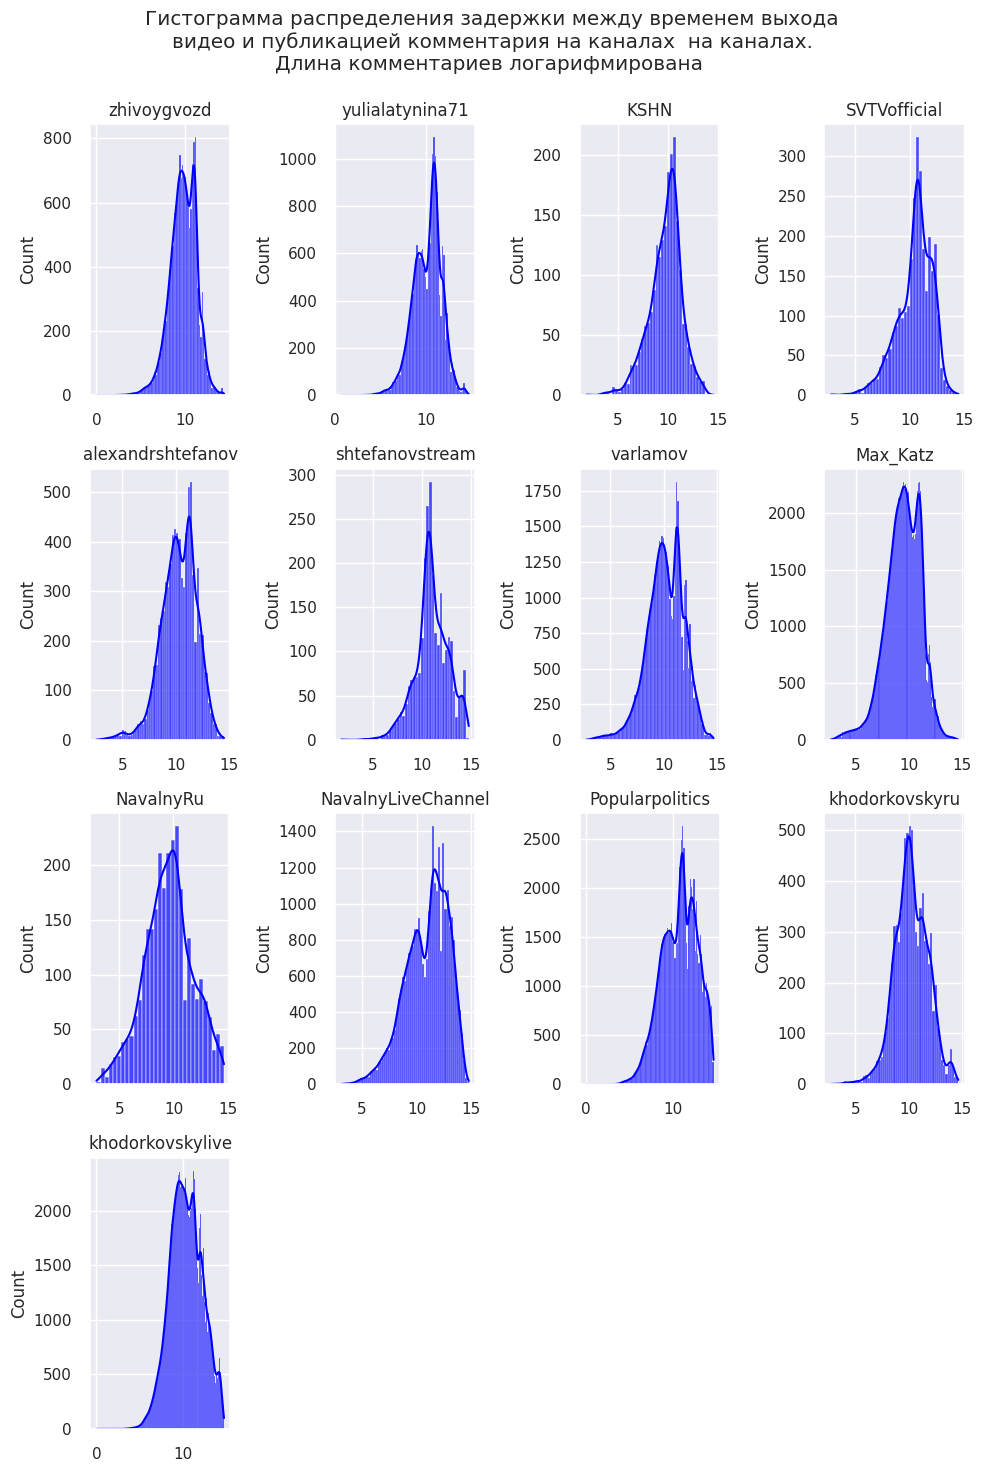

In [262]:
plt.figure(figsize=(10, 15))
plt.suptitle('Гистограмма распределения задержки между временем выхода\n' +
             'видео и публикацией комментария на каналах  на каналах.\n' +
             'Длина комментариев логарифмирована \n')
for k, i in enumerate(channels):
    plt.subplot(4, 4, k+1)
    plt.title(channel_name(i))
    sns.histplot(np.log(df[df['channelId'] == i]['commentLag'].dt.total_seconds().values),
             kde=True, alpha=.7, color='blue')

plt.tight_layout()

Для начала, будем смотреть на всю выборку, без разбивания на отдельные каналы или группы каналов.

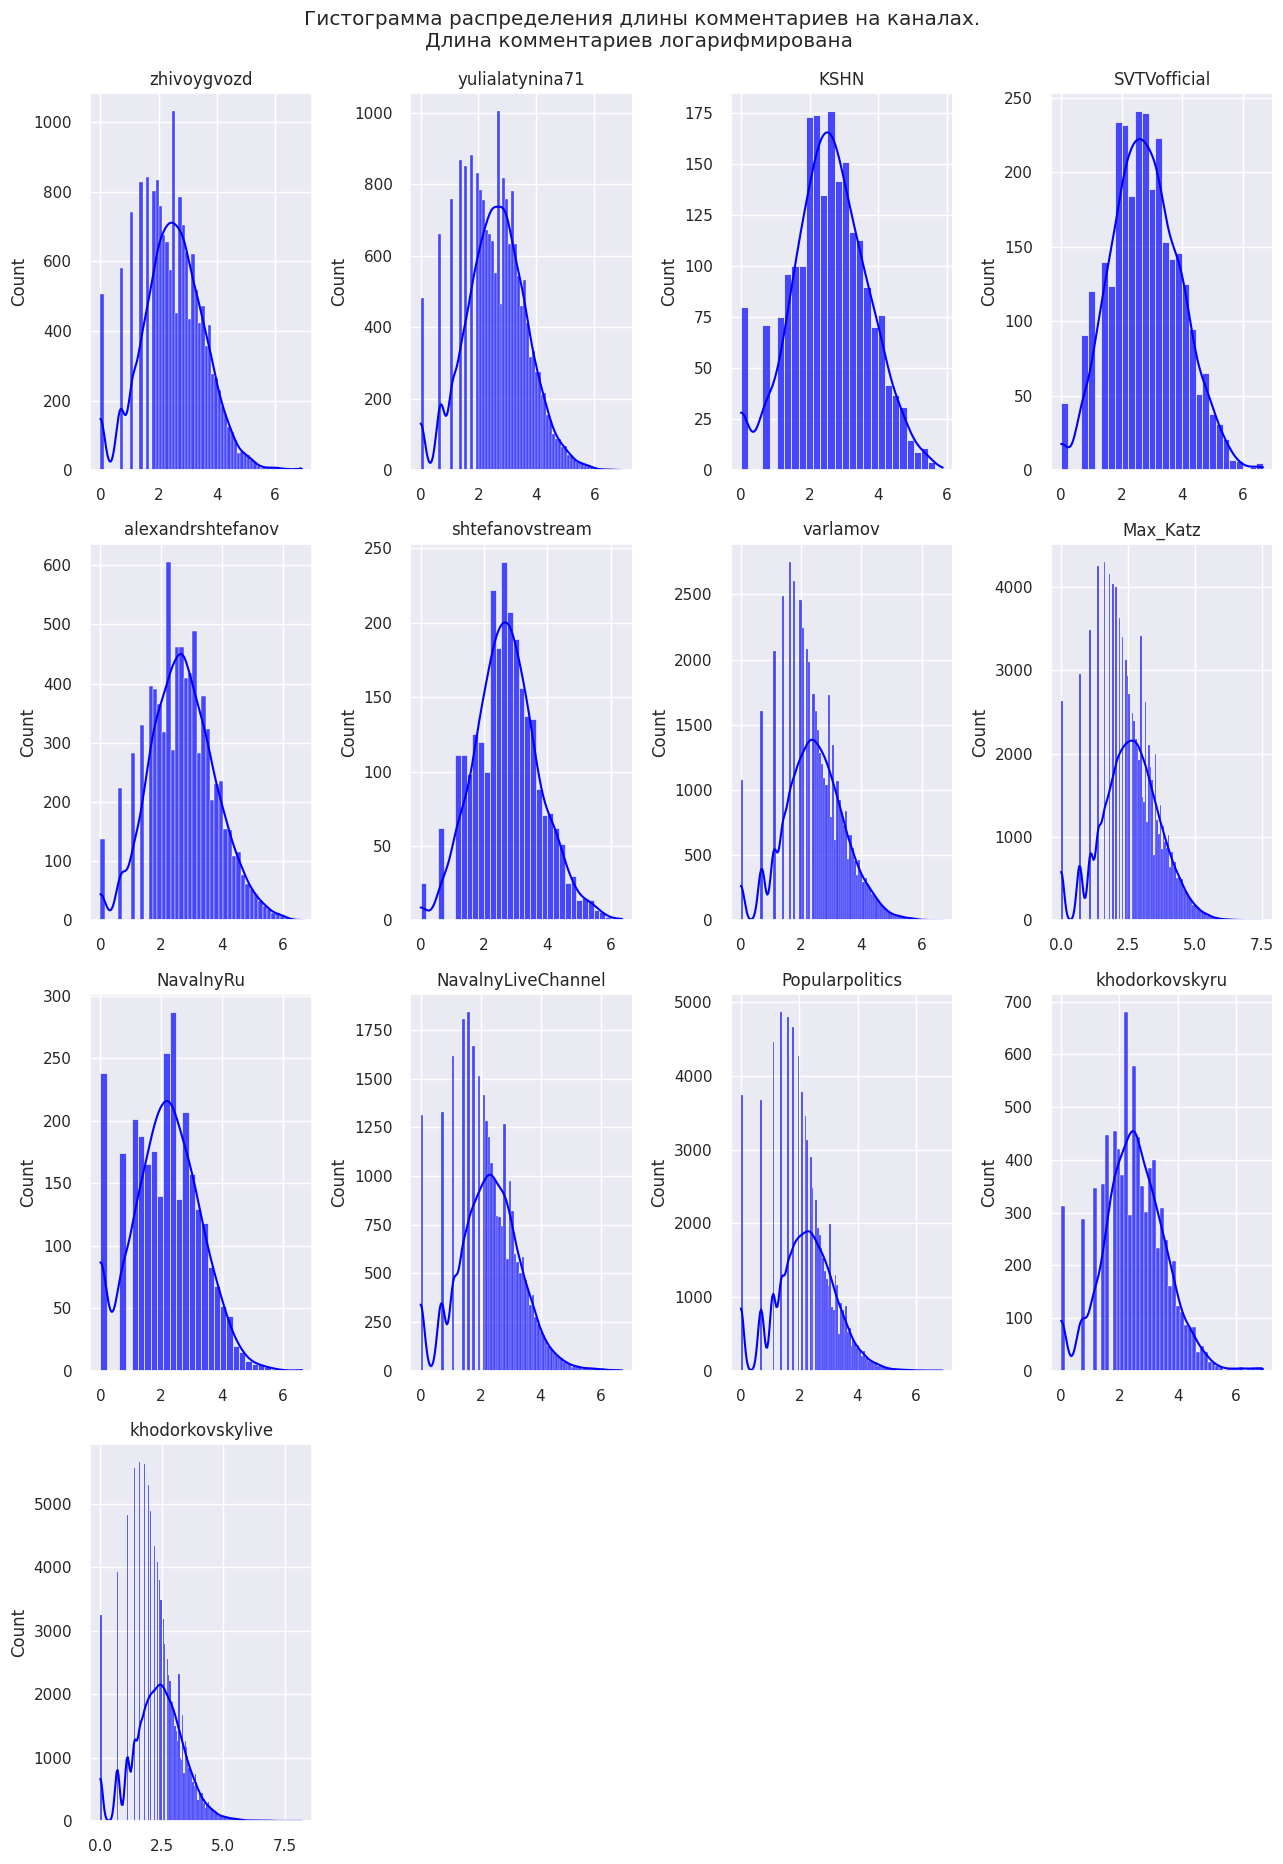

In [263]:
plt.figure(figsize=(13, 19))
plt.suptitle('Гистограмма распределения длины комментариев на каналах.\n' +
             'Длина комментариев логарифмирована \n')
for k, i in enumerate(channels):
    plt.subplot(4, 4, k+1)
    plt.title(channel_name(i))
    sns.histplot(np.log(df[df['channelId'] == i]['commentLen'].values),
             kde=True, alpha=.7, color='blue')

plt.tight_layout()

<ipython-input-264-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-264-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-264-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-264-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-264-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-264-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-264-7d218a6abd53>:7

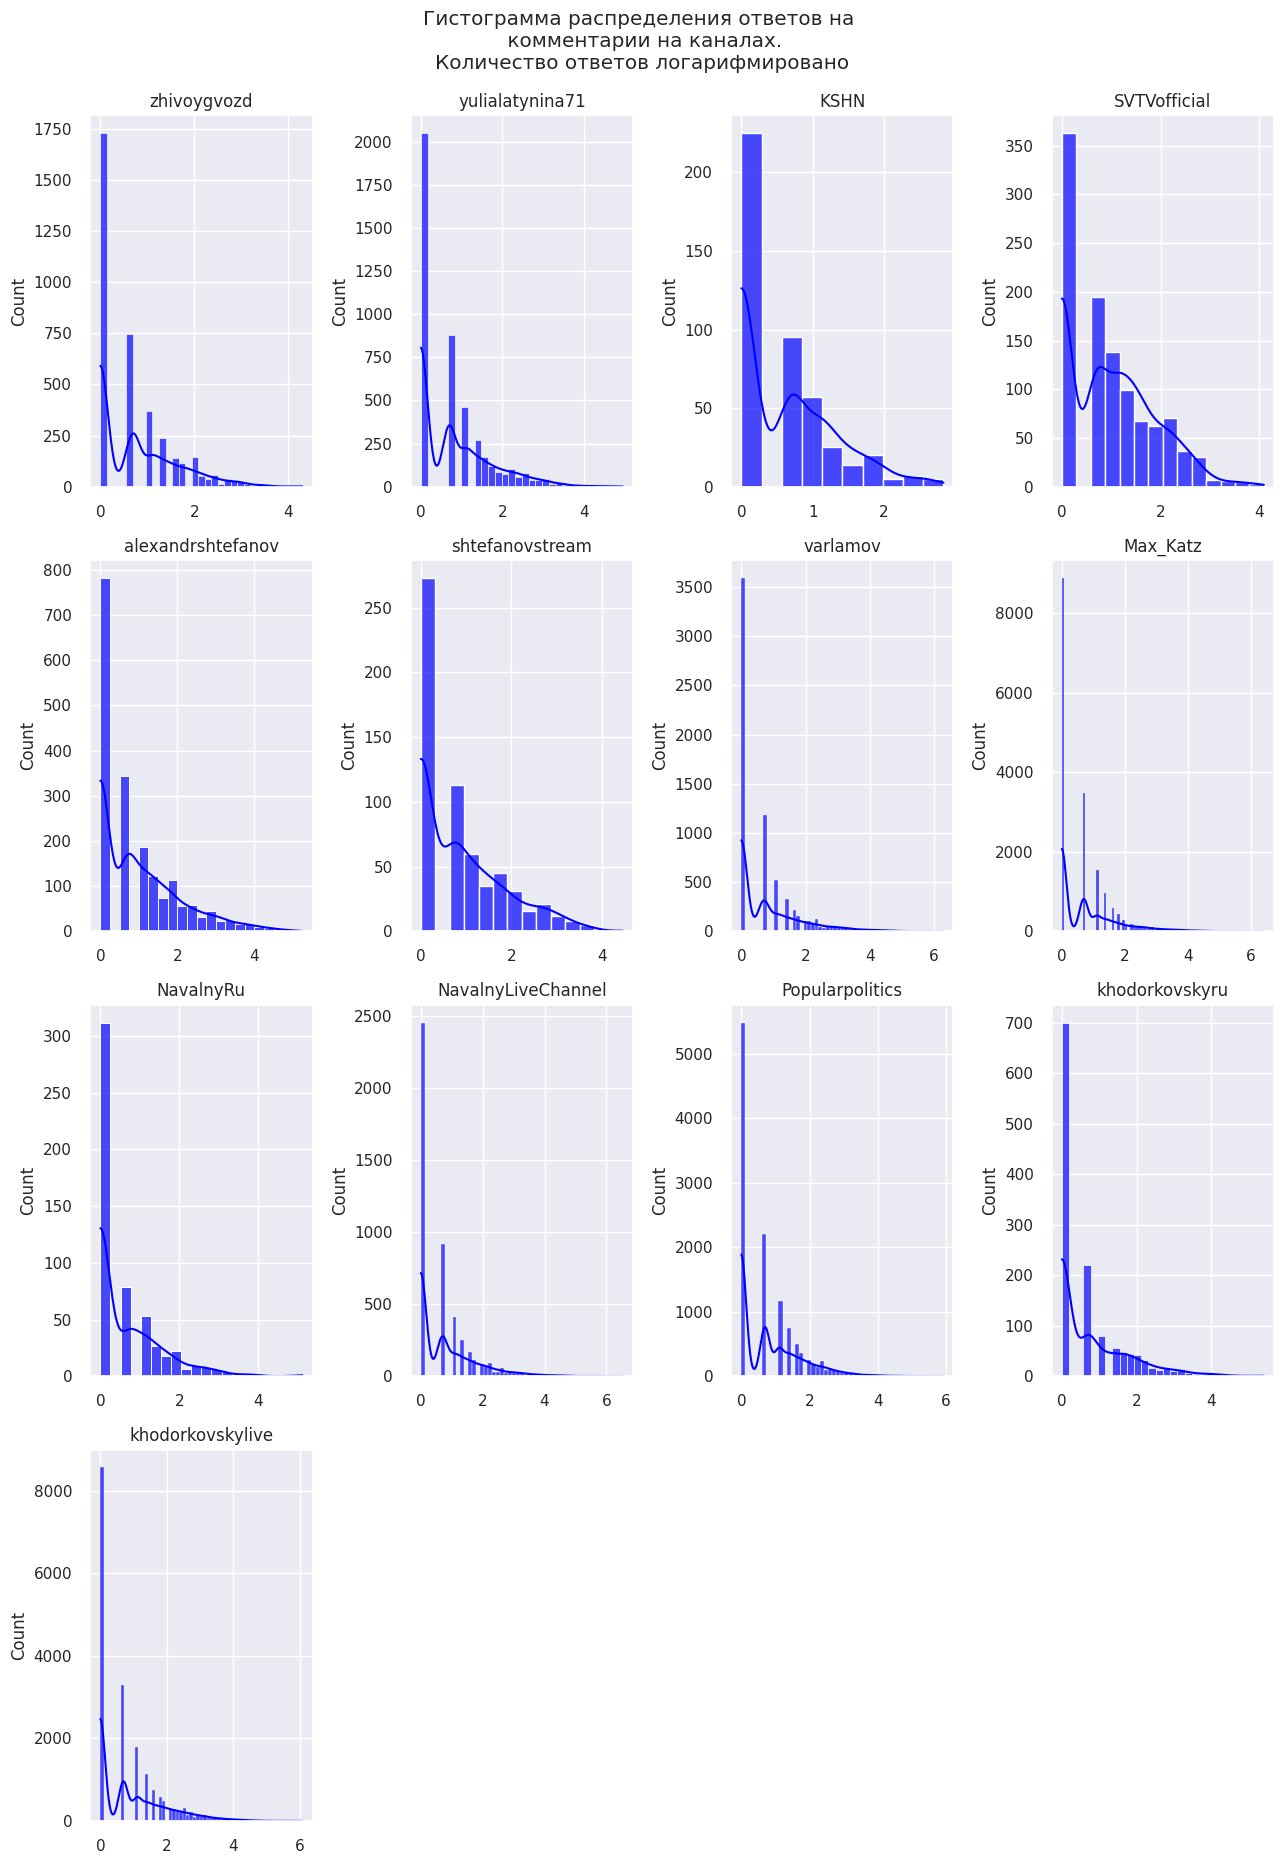

In [264]:
plt.figure(figsize=(13, 19))
plt.suptitle('Гистограмма распределения ответов на \n комментарии на каналах.\n' +
             'Количество ответов логарифмировано\n')
for k, i in enumerate(channels):
    plt.subplot(4, 4, k+1)
    plt.title(channel_name(i))
    sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
             alpha=.7, color='blue', kde=True);

plt.tight_layout();

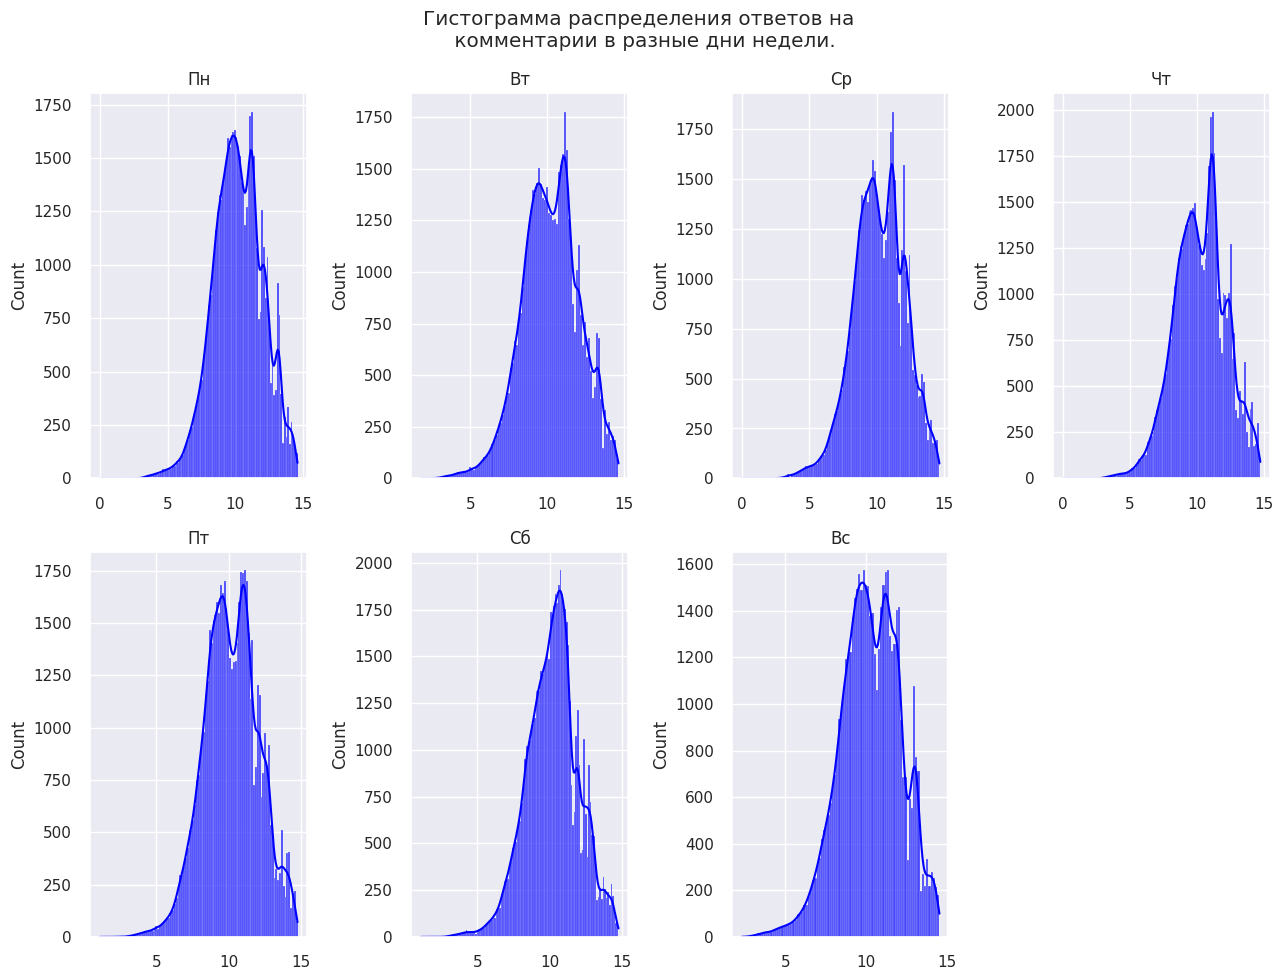

In [265]:
plt.figure(figsize=(13, 19))
plt.suptitle('Гистограмма распределения ответов на \n комментарии в разные дни недели.\n')
w = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
for k, i in enumerate(w):
    plt.subplot(4, 4, k+1)
    plt.title(w[k])
    vec = np.log(df[df['weekDayComm'] == i]['commentLag'].dt.total_seconds().values);
    sns.histplot(vec,
             alpha=.7, color='blue', kde=True);

plt.tight_layout();

In [266]:
df['commentLagLog'] = np.log(df['commentLag'].dt.total_seconds().values)
df['commentLenLog'] = np.log(df['commentLen'])

### Сделаем Scatterplot Matrix

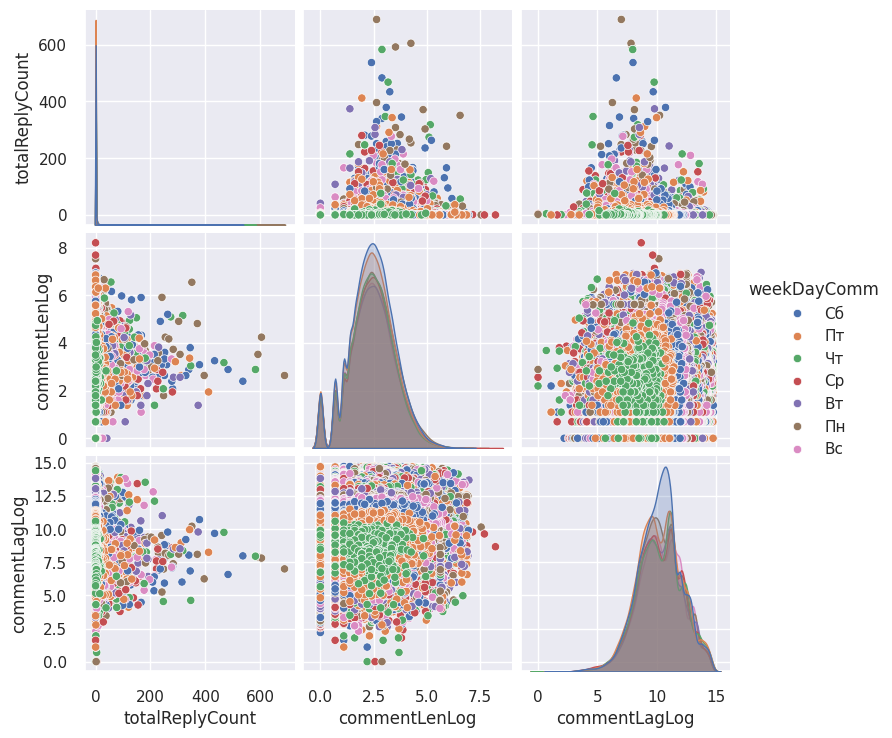

In [267]:
def ScMx(data):
    data = data[['totalReplyCount',
                'commentLenLog', 'weekDayComm',
                'commentLagLog']]
    sns.pairplot(data,
                 hue='weekDayComm')

ScMx(df)

### Комментарии в течении дня

Посмотрим, как распределяется желание людей неистово комментировать по времени

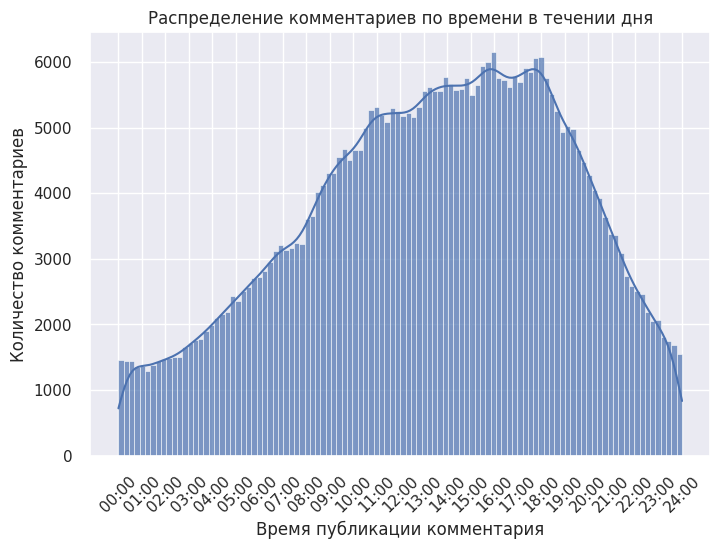

In [268]:
plt.title('Распределение комментариев по времени в течении дня')
s = df['commentDate'].dt.hour * 3600 + df['commentDate'].dt.minute * 60 + df['commentDate'].dt.second
plot = sns.histplot(s, kde=True, alpha=0.7)
plot.set(xlabel='Время публикации комментария', \
             ylabel='Количество комментариев')
ticks = range(0, 86401, 3600)  # шаг в 3600 секунд (каждый час)
labels = [f'{int(t / 3600):02}:{int((t % 3600) / 60):02}' for t in ticks]
plt.xticks(ticks, labels, rotation=45);

А теперь посмотрим распределения по дням недели

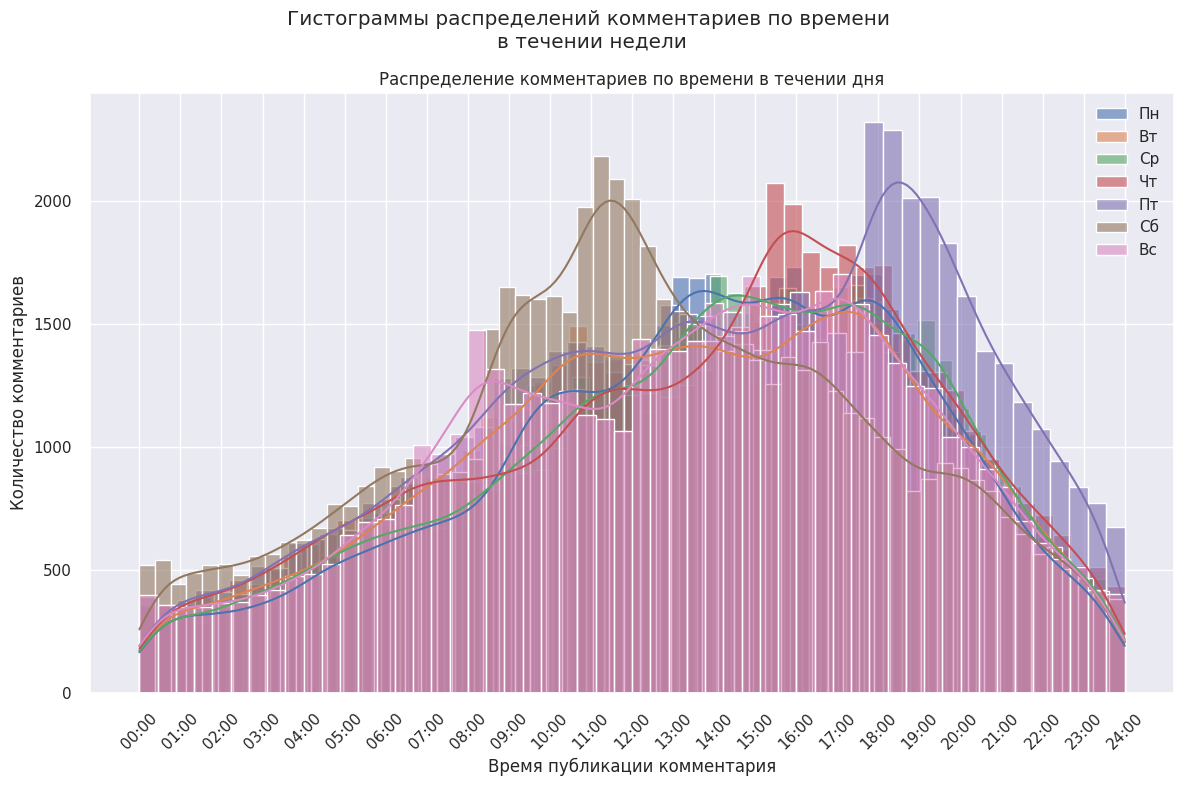

In [269]:
plt.figure(figsize=(12, 8))
plt.suptitle('Гистограммы распределений комментариев по времени \n' +
             'в течении недели')

for k, i in enumerate(w):
  plt.title('Распределение комментариев по времени в течении дня')
  s = df[df['weekDayComm'] == i]['commentDate'].dt.hour * 3600 \
    + df[df['weekDayComm'] == i]['commentDate'].dt.minute * 60 \
    + df[df['weekDayComm'] == i]['commentDate'].dt.second

  plot = sns.histplot(s, kde=True,
                      alpha=0.6, label=i)
  plot.set(xlabel='Время публикации комментария', \
               ylabel='Количество комментариев')
  ticks = range(0, 86401, 3600)  # шаг в 3600 секунд (каждый час)
  labels = [f'{int(t / 3600):02}:{int((t % 3600) / 60):02}' for t in ticks]
  plt.xticks(ticks, labels, rotation=45)

plt.legend()
plt.tight_layout();

## Гипотезы

### Ассимптоматический тест равенства средних

In [307]:
def asy_mean_test(x_control, x_treatment, alpha=0.01):
    p_c, p_t = x_control.mean(), x_treatment.mean()

    c_len, t_len = len(x_control), len(x_treatment)
    diff = p_t - p_c

    diff_std = np.sqrt(np.var(x_control, ddof=1) + np.var(x_treatment, ddof=1))


    z_obs = diff / diff_std
    p_value = 2 * (1 - sts.norm().cdf(np.abs(z_obs)))
    z_cr = sts.norm().ppf(1 - alpha)

    return z_obs, p_value, z_cr

## Тест 1: Влияет ли длина комментария на количество ответов?

* Гипотеза: $H_0$: среднее количество ответов на комментарий не различаются в зависимости от длины. $H_a$: длинные комментарии вызывают большую реакцию, чем короткие
* Метрика: Среднее количество ответов на комментарии

Для проведения теста, разобъем комментарии по медиане на две группы

In [291]:
# Находим медиану
median_value = np.median(df['commentLen'].values)

# Разбиваем на группы
x_lower = df[df['commentLen'] < median_value]['totalReplyCount'].values
x_upper = df[df['commentLen'] >= median_value]['totalReplyCount'].values

z, pval, x_cr = asy_mean_test(x_lower, x_upper, alpha=0.01)
z, pval, x_cr

(np.float64(0.09062888944571795),
 np.float64(0.9277874759302569),
 np.float64(2.3263478740408408))

Средние слишком близки, гипотеза ложна

Переформулируем гипотезу. Будем сравнивать комментарии средней длины с группой длинных и коротких.

In [303]:
# Находим квантили
q1 = df['commentLen'].quantile(0.33)  # Первый квартиль (низший 33%)
q2 = df['commentLen'].quantile(0.66)  # Второй квартиль (низший 66%)

# Разбиваем на группы
x_mid = df[(df['commentLen'] > q1) & (df['commentLen'] <= q2)]['totalReplyCount'].values  # Значения между первым и вторым квартилем
x_extremal = df[(df['commentLen'] <= q1) | (df['commentLen'] > q2)]['totalReplyCount'].values  # Значения больше второго квартиля

z, pval, x_cr = asy_mean_test(x_mid, x_extremal, alpha=0.01)
z, pval, x_cr

0.8875481061184649 0.9281616776848913 -0.04061357156642642 8.981072173041165


(np.float64(-0.004522129516822921),
 np.float64(0.9963918749740659),
 np.float64(2.3263478740408408))

Такой подход тоже не дает статистически значимого результата

In [276]:
a, b = np.random.choice(x_lower, size=50000), np.random.choice(x_upper, size=50000)
asy_mean_test(a, b)

0.82966 8.9764989081408 0.09242578966367167


(np.float64(0.09242578966367167),
 np.float64(0.926359749933837),
 np.float64(2.5758293035489004))

Для каждого из каналов выведем множество уникальных комментаторов

## Тест 2: отличаются ли средние длины комментариев на разных каналах?

In [318]:
unical_commentators = defaultdict(list)
tabel = pd.DataFrame()
for i in tqdm(channels):
    for k in channels:
      a = df[df['channelId'] == i]['commentLen']
      b = df[df['channelId'] == k]['commentLen']
      z, pval, z_crit = asy_mean_test(a, b, alpha=0.01)
      tabel.loc[channel_name(i), channel_name(k)] = f'res = {z < z_crit and z > -z_crit}z_obs = {z}, pval={pval}, z_cr={z_crit}'

tabel

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


,zhivoygvozd,yulialatynina71,KSHN,SVTVofficial,alexandrshtefanov,shtefanovstream,varlamov,Max_Katz,NavalnyRu,NavalnyLiveChannel,Popularpolitics,khodorkovskyru,khodorkovskylive
zhivoygvozd,"res = Truez_obs = 0.0, pval=1.0, z_cr=2.326347...","res = Truez_obs = 0.026700863131501242, pval=0...","res = Truez_obs = 0.023268670368866994, pval=0...","res = Truez_obs = 0.13755966385986282, pval=0....","res = Truez_obs = 0.08406300488774418, pval=0....","res = Truez_obs = 0.06932768558385095, pval=0....","res = Truez_obs = -0.059280095873082445, pval=...","res = Truez_obs = 0.037113302241228906, pval=0...","res = Truez_obs = -0.12782773839729603, pval=0...","res = Truez_obs = -0.09613347553193943, pval=0...","res = Truez_obs = -0.14036888943789702, pval=0...","res = Truez_obs = 0.012267171578938453, pval=0...","res = Truez_obs = -0.07105409360947773, pval=0..."
yulialatynina71,"res = Truez_obs = -0.026700863131501242, pval=...","res = Truez_obs = 0.0, pval=1.0, z_cr=2.326347...","res = Truez_obs = -0.0055034153563387435, pval...","res = Truez_obs = 0.12225789207433038, pval=0....","res = Truez_obs = 0.06358553299427713, pval=0....","res = Truez_obs = 0.047103636210046186, pval=0...","res = Truez_obs = -0.09830481390971726, pval=0...","res = Truez_obs = 0.01190390829185324, pval=0....","res = Truez_obs = -0.17591578407054206, pval=0...","res = Truez_obs = -0.1379976577086021, pval=0....","res = Truez_obs = -0.19089562547795355, pval=0...","res = Truez_obs = -0.010846083573500528, pval=...","res = Truez_obs = -0.10717687063922963, pval=0..."
KSHN,"res = Truez_obs = -0.023268670368866994, pval=...","res = Truez_obs = 0.0055034153563387435, pval=...","res = Truez_obs = 0.0, pval=1.0, z_cr=2.326347...","res = Truez_obs = 0.13203577204228287, pval=0....","res = Truez_obs = 0.07248148894415338, pval=0....","res = Truez_obs = 0.05544131956933072, pval=0....","res = Truez_obs = -0.10090788893878816, pval=0...","res = Truez_obs = 0.018050687949143666, pval=0...","res = Truez_obs = -0.18621852035462277, pval=0...","res = Truez_obs = -0.1436872989625492, pval=0....","res = Truez_obs = -0.20314801684224223, pval=0...","res = Truez_obs = -0.006934963691892944, pval=...","res = Truez_obs = -0.1093885662063901, pval=0...."
SVTVofficial,"res = Truez_obs = -0.13755966385986282, pval=0...","res = Truez_obs = -0.12225789207433038, pval=0...","res = Truez_obs = -0.13203577204228287, pval=0...","res = Truez_obs = 0.0, pval=1.0, z_cr=2.326347...","res = Truez_obs = -0.06381893514812752, pval=0...","res = Truez_obs = -0.08072572360717353, pval=0...","res = Truez_obs = -0.207233405739123, pval=0.8...","res = Truez_obs = -0.1105892003281633, pval=0....","res = Truez_obs = -0.2680898184317815, pval=0....","res = Truez_obs = -0.2371690886767077, pval=0....","res = Truez_obs = -0.2798860351264709, pval=0....","res = Truez_obs = -0.11577601356322498, pval=0...","res = Truez_obs = -0.2096312367117825, pval=0...."
alexandrshtefanov,"res = Truez_obs = -0.08406300488774418, pval=0...","res = Truez_obs = -0.06358553299427713, pval=0...","res = Truez_obs = -0.07248148894415338, pval=0...","res = Truez_obs = 0.06381893514812752, pval=0....","res = Truez_obs = 0.0, pval=1.0, z_cr=2.326347...","res = Truez_obs = -0.017538706257635327, pval=...","res = Truez_obs = -0.1597285212844383, pval=0....","res = Truez_obs = -0.05113572754635135, pval=0...","res = Truez_obs = -0.23155035267550497, pval=0...","res = Truez_obs = -0.19514796110338378, pval=0...","res = Truez_obs = -0.24565786622644437, pval=0...","res = Truez_obs = -0.06364391416359792, pval=0...","res = Truez_obs = -0.16388154502296048, pval=0..."
shtefanovstream,"res = Truez_obs = -0.06932768558385095, pval=0...","res = Truez_obs = -0.047103636210046186, pval=...","res = Truez_obs = -0.05544131956933072, pval=0...","res = Truez_obs = 0.08072572360717353, pval=0....","res = Truez_obs = 0.017538706257635327, pval=0...","res = Truez_obs = 0.0, pval=1.0, z_cr=2.326347...","res = Truez_obs = -0.1459663086088344, pval=0....",

Различия найти не удалось